In [114]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd
from astropy.timeseries import LombScargle
import lightkurve as lk
from scipy.optimize import minimize_scalar
from scipy.signal import find_peaks
from scipy.optimize import Bounds

In [74]:
# Rotation period value as found in the paper ("HADES RV Programme with HARPS-N at TNG")
rp = 15.7

# SuperWASP Dataset

In [22]:
SuperWASP_data = "/Users/andrewandmatthewfonseca/Downloads/plot.tbl"
y = pd.read_table(SuperWASP_data, comment='#', delim_whitespace=True)
colnames = ['HJD', 'TAMMAG2', 'T']
data = pd.read_csv(SuperWASP_data, comment="#", header=0, names=colnames, delim_whitespace=True, skiprows=3)
# Add titles and labels to plots of SuperWASP data

          \fixlen               =             T
0        |set|HJD        |TAMMAG2             |
1     |int|double         |double             |
2               0  2453837.533565  1.015264e+01
3               0  2453837.544664  1.015876e+01
4               0  2453837.549965  1.017314e+01
...           ...             ...           ...
7369            0  2454586.729572  1.021606e+01
7370            0  2454586.731273  1.019219e+01
7371            0  2454586.731713  1.020349e+01
7372            0  2454586.734641  1.022221e+01
7373            0  2454586.735081  1.021718e+01

[7374 rows x 3 columns]


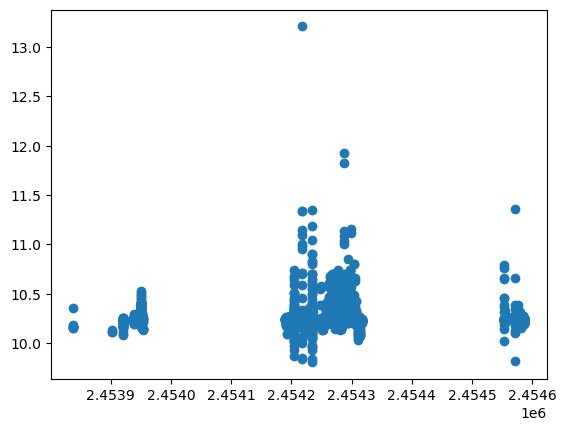

In [23]:
# Scatter Plot of SuperWASP data
set, jd, tammag2 = np.loadtxt(SuperWASP_data, skiprows=3, unpack=True)
plt.scatter(jd, tammag2)
print(y)

(array([4.491e+03, 2.141e+03, 5.800e+02, 3.900e+01, 1.000e+00, 9.000e+01,
        2.000e+01, 4.000e+00, 2.000e+00, 3.000e+00]),
 array([-3.38090677, -2.80531975, -2.22973273, -1.65414571, -1.07855869,
        -0.50297168,  0.07261534,  0.64820236,  1.22378938,  1.7993764 ,
         2.37496342]),
 <BarContainer object of 10 artists>)

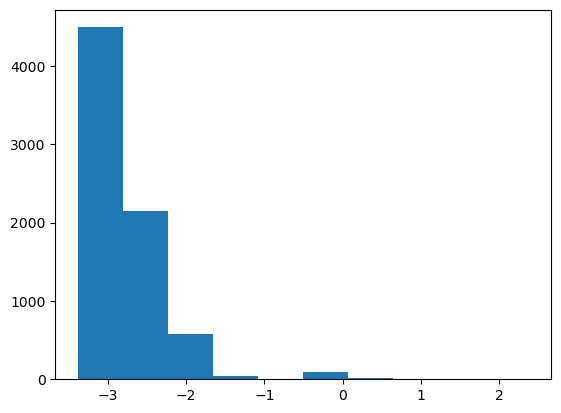

In [24]:
# Histogram of SuperWASP data
dt = np.diff(jd)
plt.hist(np.log10(dt))

(0.0, 0.5)

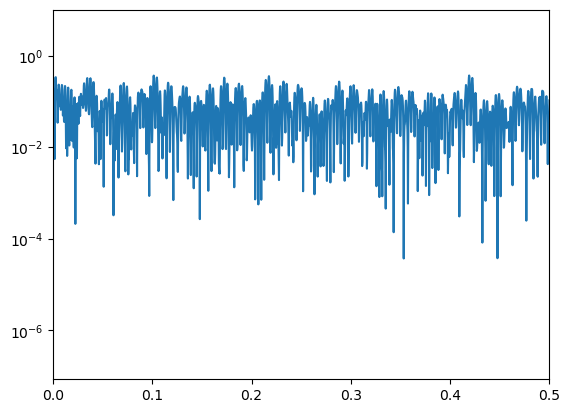

In [25]:
# Periodogram of SuperWASP data
frequency_sw, power_sw = LombScargle(jd - jd[0], tammag2, normalization="psd").autopower()
plt.semilogy(frequency_sw, power_sw)
plt.xlim(0, 0.5)

In [26]:
max_index_sw = np.argmax(power_sw)
print(frequency_sw[max_index_sw])
rotation_sw = 1/frequency_sw[max_index_sw]
rp/rotation_sw 
#This leads the rotation being 1, which then gives back the same number, 16.21875

1.002800960696906


16.3356276497526

<Axes: xlabel='Time [JD]', ylabel='Flux'>

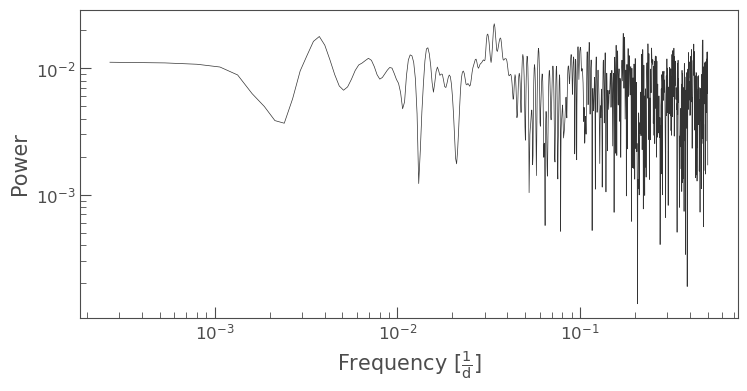

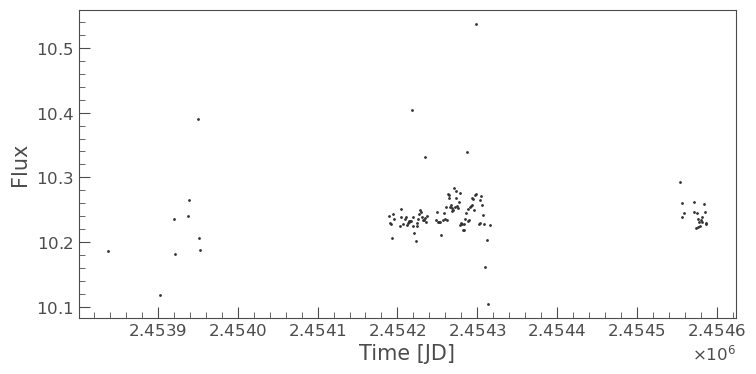

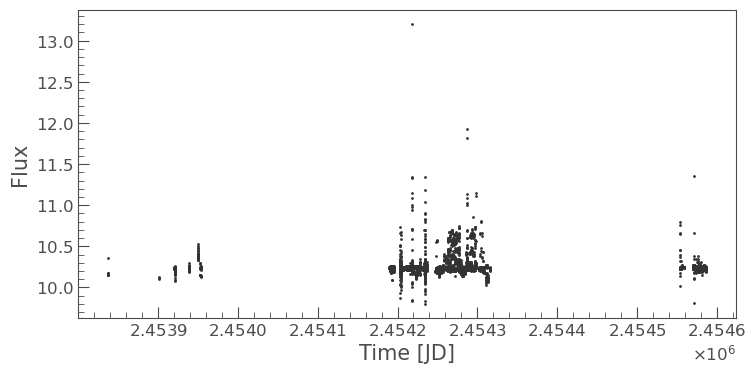

In [27]:
# Original binned lightcurve
my_lightcurve = lk.LightCurve(time=jd, flux=tammag2)
my_lightcurve_bin = my_lightcurve.bin(time_bin_size=1)
lightcurve_periodogram = my_lightcurve_bin.to_periodogram(method='lombscargle')
lightcurve_periodogram.plot(scale='log')
my_lightcurve_bin.scatter()
my_lightcurve.scatter()
#print(my_lightcurve_bin)
#print(my_lightcurve.flux)
#print(tammag2)
# The columns of the binned lightcurve are the time, flux, flux_err, time_bin_start, and time bin_size.
# The binned lightcurve is 750 rows long.

## Spectral Window of SuperWASP data (no lightcurve vs. lightcurve)

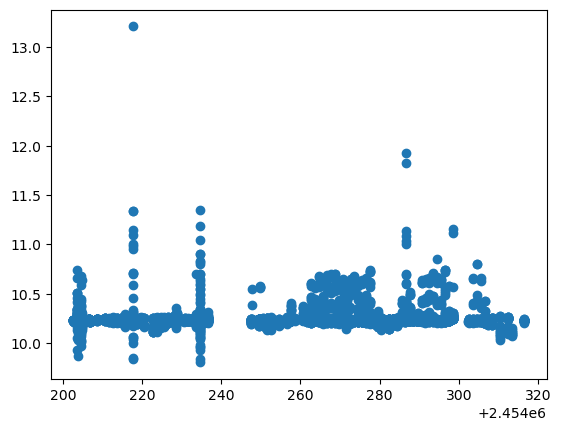

In [28]:
# Cutting data to have only main data
main_data = []
for j in range(len(jd)):
    if (jd[j] > 2.4542e6) and (jd[j] < 2.4544e6):
        main_data.append(j)
main_jd = jd[main_data]
main_tammag2 = tammag2[main_data]
plt.scatter(main_jd, main_tammag2)

(0.01, 10000.0)

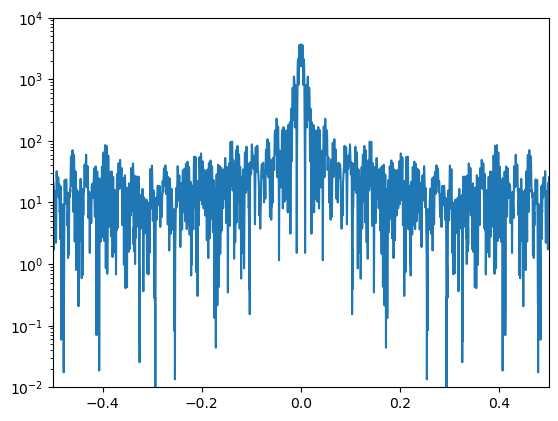

In [29]:
# Lomb-Scargle (spectral window) (all data) [1]
plt.figure()
freq, specwin = LombScargle(jd - jd[0], np.ones(len(jd)), center_data = False, fit_mean = False, normalization = 'psd').autopower(nyquist_factor=2)
plt.semilogy(np.concatenate((-freq[::-1], freq[1:])), np.concatenate((specwin[::-1], specwin[1:])))
plt.xlim(-0.5, 0.5)
plt.ylim(1e-2, 1e4)

(0.01, 10000.0)

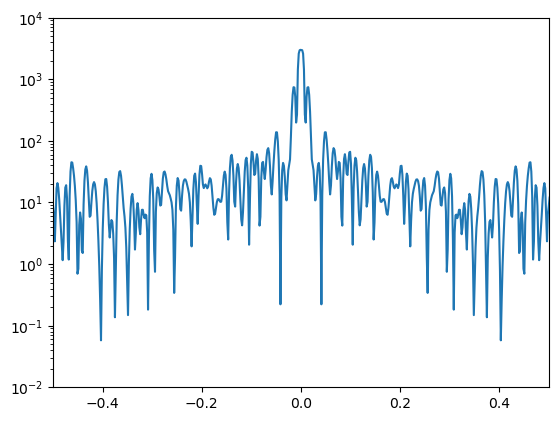

In [30]:
# Lomb-Scargle (cut data)
plt.figure()
freq, specwin = LombScargle(main_jd - main_jd[0], np.ones(len(main_jd)), center_data = False, fit_mean = False, normalization = 'psd').autopower(nyquist_factor=2)
plt.semilogy(np.concatenate((-freq[::-1], freq[1:])), np.concatenate((specwin[::-1], specwin[1:])))
plt.xlim(-0.5, 0.5)
plt.ylim(1e-2, 1e4)

(0.0, 0.5)

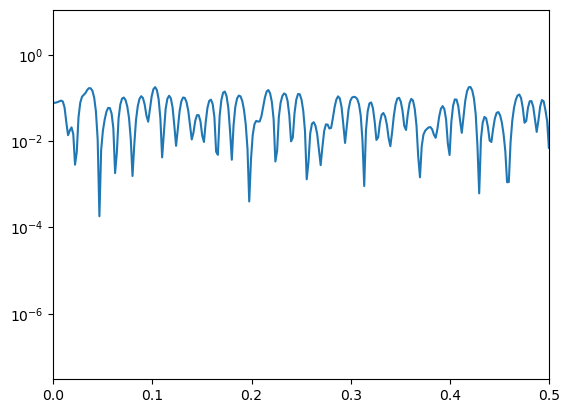

In [31]:
# Periodogram of SuperWASP data
plt.figure()
cut_frequency, cut_power = LombScargle(main_jd - main_jd[0], main_tammag2, normalization="psd").autopower()
plt.semilogy(cut_frequency, cut_power)
plt.xlim(0, 0.5)

(0.01, 10000.0)

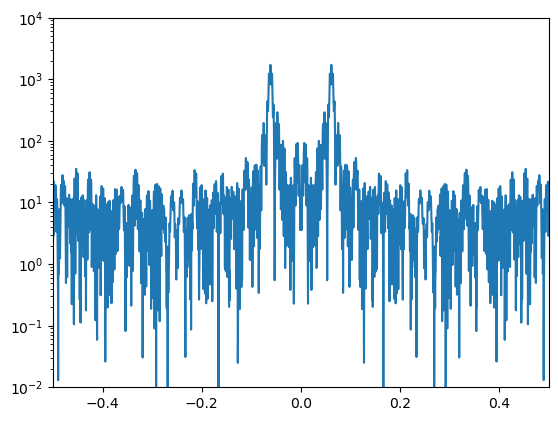

In [32]:
# Pesudo-window (uncut, unbinned) [2]
plt.figure()
freq, specwin = LombScargle(jd - jd[0], np.sin(2*np.pi*(jd-jd[0])/rp), center_data = False, fit_mean = False, normalization = 'psd').autopower(nyquist_factor=2)
plt.semilogy(np.concatenate((-freq[::-1], freq[1:])), np.concatenate((specwin[::-1], specwin[1:])))
plt.xlim(-0.5, 0.5)
plt.ylim(1e-2, 1e4)

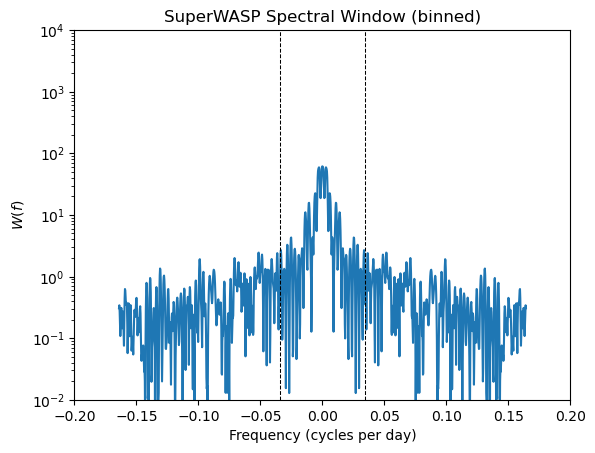

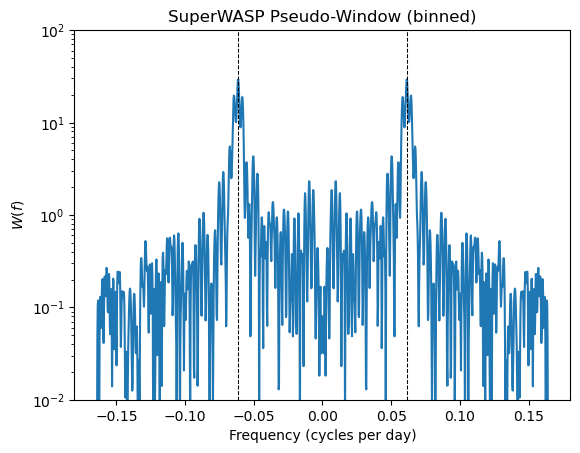

In [66]:
# Pseudo-Window for binned Lightcurve
bin_time = my_lightcurve_bin_new.time.value

plt.figure()
plt.title("SuperWASP Spectral Window (binned)")
plt.ylabel(r"$W(f)$")
plt.xlabel(r"Frequency (cycles per day)")
freq, specwin = LombScargle(bin_time - bin_time[0], np.ones(len(bin_time)), center_data = False, fit_mean = False, normalization = 'psd').autopower(nyquist_factor=2)
plt.semilogy(np.concatenate((-freq[::-1], freq[1:])), np.concatenate((specwin[::-1], specwin[1:])))
plt.xlim(-0.2, 0.2)
plt.ylim(1e-2, 1e4)
#make this line a dotted-line for harmonic
plt.axvline(1/29.5, linestyle='--', linewidth=0.75, color='black')
plt.axvline(-(1/29.5), linestyle='--', linewidth=0.75, color='black')

plt.figure()
plt.title("SuperWASP Pseudo-Window (binned)")
plt.ylabel(r"$W(f)$")
plt.xlabel(r"Frequency (cycles per day)")
freq, specwin = LombScargle(bin_time - bin_time[0], np.sin(2*np.pi*(bin_time-bin_time[0])/rp), center_data = False, fit_mean = False, normalization = 'psd').autopower(nyquist_factor=2)
plt.semilogy(np.concatenate((-freq[::-1], freq[1:])), np.concatenate((specwin[::-1], specwin[1:])))
#plt.xlim(-0.2, 0.2)
plt.ylim(1e-2, 1e2)
#make these lines a dotted-line for the harmonics
plt.axvline(1/rp, linestyle='--', linewidth=0.75, color='black')
plt.axvline(-(1/rp), linestyle='--', linewidth=0.75, color='black')

In [36]:
# Maximum frequency and period
frequency_peak = lightcurve_periodogram.frequency_at_max_power
period_associated = 1 / frequency_peak
print("Frequency of Maximum Power (Peak):", frequency_peak)
print("Period associated with the peak:", period_associated)
# test by getting binned data points from lighcurve

Frequency of Maximum Power (Peak): 0.033911882510013355 1 / d
Period associated with the peak: 29.48818897637795 d


     time             flux        ... time_bin_start time_bin_size
                                  ...                      d      
-------------- ------------------ ... -------------- -------------
2453838.033565        10.18547625 ... 2453837.533565           1.0
2453902.033565 10.117193333333333 ... 2453901.533565           1.0
2453920.033565 10.235812500000002 ... 2453919.533565           1.0
2453921.033565 10.181635652173911 ... 2453920.533565           1.0
2453938.033565 10.240692333333335 ... 2453937.533565           1.0
2453939.033565         10.2654525 ... 2453938.533565           1.0
           ...                ... ...            ...           ...
2454580.033565 10.233751630434782 ... 2454579.533565           1.0
2454581.033565 10.238334788732395 ... 2454580.533565           1.0
2454582.033565        10.23080625 ... 2454581.533565           1.0
2454584.033565 10.258438333333332 ... 2454583.533565           1.0
2454585.033565 10.245749215686274 ... 2454584.533565          

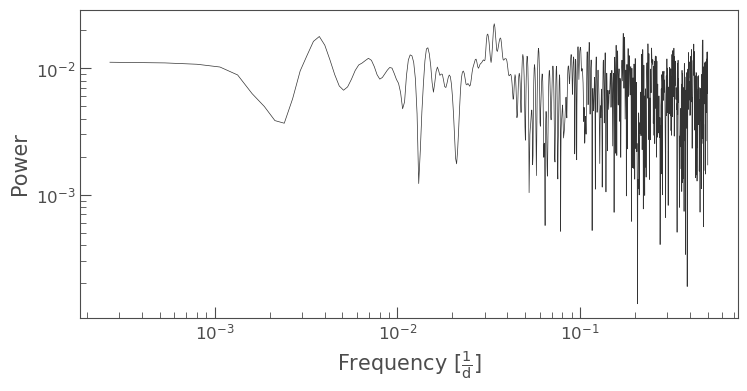

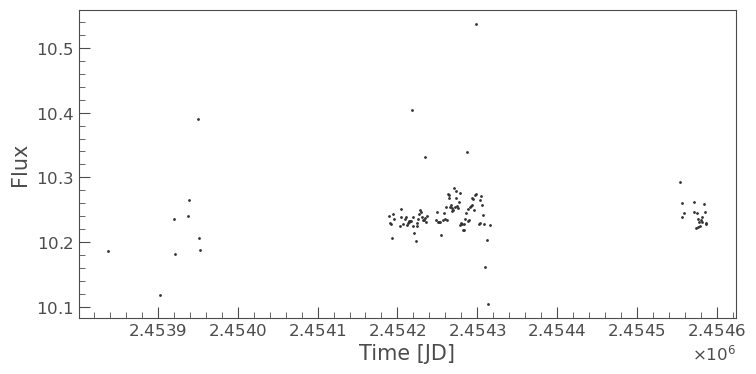

In [34]:
# Removing NaN data from binned lightcurve (rename to remove confusion)
my_lightcurve_bin_new = my_lightcurve_bin.remove_nans()
lightcurve_periodogram_new = my_lightcurve_bin_new.to_periodogram(method='lombscargle')
lightcurve_periodogram_new.plot(scale='log')
my_lightcurve_bin_new.scatter()
print(my_lightcurve_bin_new) #To untruncate, using a for loop to iterate through the list
# The original binned lightcurve didnt plot the NaN's anyways; it would be the same plot

# Hipparcos Dataset

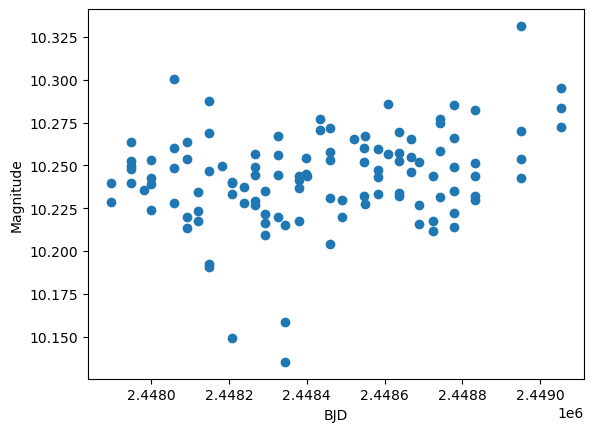

In [37]:
# Scatter plot of sigma-clipped Hipparcos data
Hipp = "/Users/andrewandmatthewfonseca/Downloads/UID_0079126_PLC_001.tbl.txt"
bjd, mag = np.loadtxt(Hipp, skiprows=123, unpack=True, usecols=[0, 1])
std_dev = np.std(mag)
good_data = np.where(np.abs(mag - np.mean(mag)) < 3 * std_dev)[0]
bjd = bjd[good_data]
mag = mag[good_data]
plt.scatter(bjd, mag)
plt.xlabel('BJD')
plt.ylabel('Magnitude')
len(bjd)

# unclipped Hipparcos Data
bjd_full, mag_full = np.loadtxt(Hipp, skiprows=123, unpack=True, usecols=[0, 1])

(array([48., 32.,  2.,  0.,  0.,  0.,  0.,  4., 23.,  5.]),
 array([-1.8452718 , -1.45408204, -1.06289229, -0.67170253, -0.28051277,
         0.11067698,  0.50186674,  0.8930565 ,  1.28424625,  1.67543601,
         2.06662576]),
 <BarContainer object of 10 artists>)

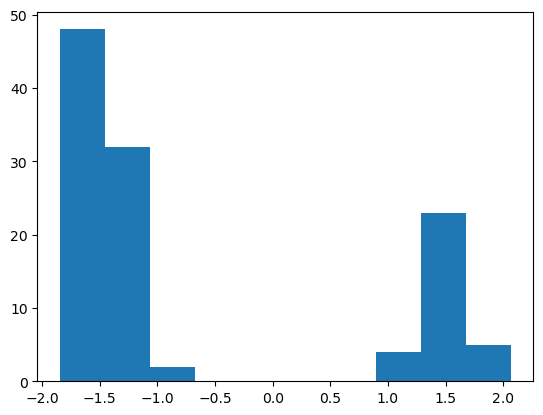

In [38]:
# Histogram of Hipparcos data
dt = np.diff(bjd)
plt.hist(np.log10(dt))

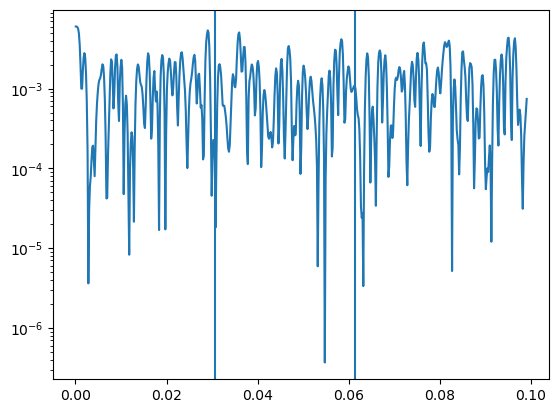

In [39]:
# Lomb-Scargle of Hipparcos data (clipped data)
freq, power = LombScargle(bjd, mag, normalization = 'psd').autopower(nyquist_factor=2)
plt.semilogy(freq, power)
plt.axvline(1/rp)
plt.axvline((1/rp)/2)

(0.1, 100)

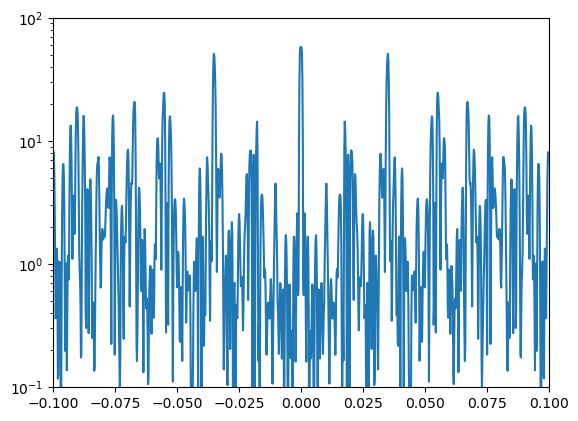

In [40]:
# Lomb-Scargle (full data) of Hipparcos
plt.figure()
freq, specwin = LombScargle(bjd_full - bjd_full[0], np.ones(len(bjd_full)), center_data = False, fit_mean = False, normalization = 'psd').autopower(nyquist_factor=2)
plt.semilogy(np.concatenate((-freq[::-1], freq[1:])), np.concatenate((specwin[::-1], specwin[1:])))
plt.xlim(-0.1, 0.1)
plt.ylim(1e-1, 100)

(-0.1, 0.1)

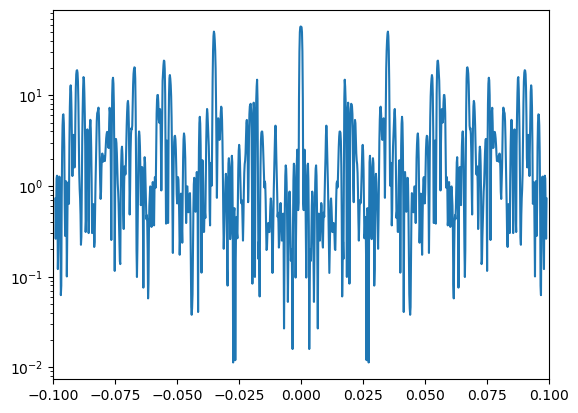

In [41]:
# Lomb-Scargle (clipped data) of Hipparcos
plt.figure()
freq, specwin = LombScargle(bjd - bjd[0], np.ones(len(bjd)), center_data = False, fit_mean = False, normalization = 'psd').autopower(nyquist_factor=2)
plt.semilogy(np.concatenate((-freq[::-1], freq[1:])), np.concatenate((specwin[::-1], specwin[1:])))
plt.xlim(-0.1, 0.1)

(0.0, 0.25)

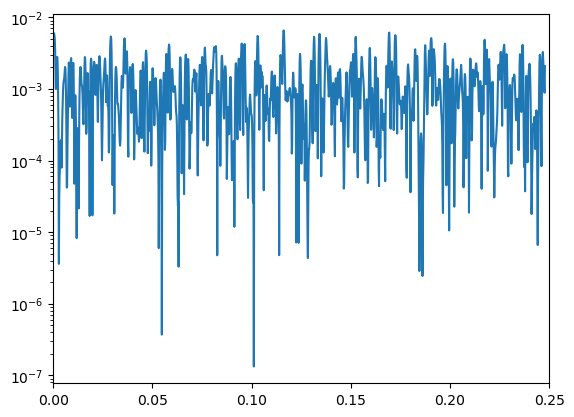

In [42]:
# Periodogram of Hipparcos data
plt.figure()
cut_frequency, cut_power = LombScargle(bjd - bjd[0], mag, normalization="psd").autopower()
plt.semilogy(cut_frequency, cut_power)
plt.xlim(0, 0.25)

(-0.1, 0.1)

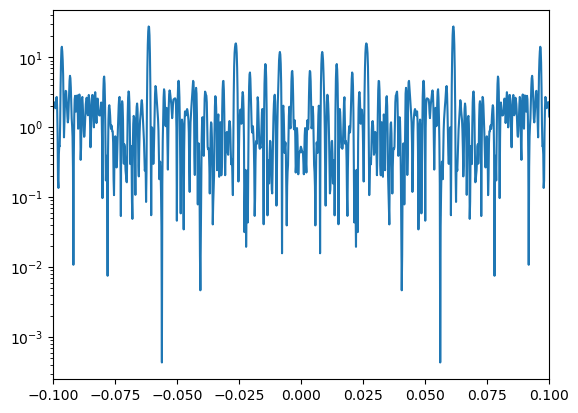

In [43]:
# Pesudo-window (unclipped) of Hipparcos
plt.figure()
freq, specwin = LombScargle(bjd_full - bjd_full[0], np.sin(2*np.pi*(bjd_full-bjd_full[0])/rp), center_data = False, fit_mean = False, normalization = 'psd').autopower(nyquist_factor=2)
plt.semilogy(np.concatenate((-freq[::-1], freq[1:])), np.concatenate((specwin[::-1], specwin[1:])))
plt.xlim(-0.1, 0.1)

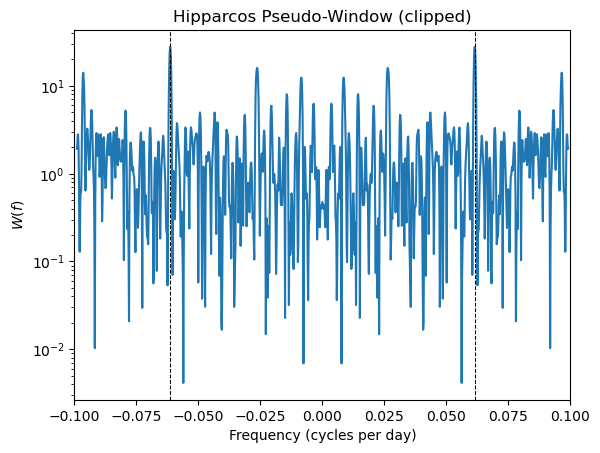

In [63]:
# Pseudo-Window for clipped data
plt.figure()
plt.title("Hipparcos Pseudo-Window (clipped)")
plt.ylabel(r"$W(f)$")
plt.xlabel(r"Frequency (cycles per day)")
freq, specwin = LombScargle(bjd - bjd[0], np.sin(2*np.pi*(bjd-bjd[0])/rp), center_data = False, fit_mean = False, normalization = 'psd').autopower(nyquist_factor=2)
plt.semilogy(np.concatenate((-freq[::-1], freq[1:])), np.concatenate((specwin[::-1], specwin[1:])))
plt.xlim(-0.1, 0.1)
plt.axvline(1/rp, linestyle='--', linewidth=0.75, color='black')
plt.axvline(-(1/rp), linestyle='--', linewidth=0.75, color='black')

In [45]:
# Run speactral and psudeo window of Hipparcos data
# find wave length coverage of the filters of test filter (MAST), SuperWASP filter, and Hipparcos (Hp filter)
# move superWASP data to seperate notebook
# add shaded resoulution to hipparcos
# for later, detrend Hipparcos.
# look at observation period for TESS, Hipparcos, and SuperWASP.

# TESS Datasets

## TESS Functions

In [1]:
#MAST file paths
MAST1 = "/Users/andrewandmatthewfonseca/Downloads/MAST_2024-03-13T1207/TESS/tess2020078014623-s0023-0000000162494287-0177-s/tess2020078014623-s0023-0000000162494287-0177-s_lc.fits"
MAST2 = "/Users/andrewandmatthewfonseca/Downloads/MAST_2024-03-13T1209/TESS/tess2022112184951-s0051-0000000162494287-0223-s/tess2022112184951-s0051-0000000162494287-0223-s_lc.fits"
MAST3 = "/Users/andrewandmatthewfonseca/Downloads/MAST_2024-03-13T1209-2/TESS/tess2022085151738-s0050-0000000162494287-0222-s/tess2022085151738-s0050-0000000162494287-0222-s_lc.fits"
MAST4 = "/Users/andrewandmatthewfonseca/Downloads/MAST_2024-03-13T1209-3/TESS/tess2022138205153-s0052-0000000162494287-0224-s/tess2022138205153-s0052-0000000162494287-0224-s_lc.fits"
MAST5 = "/Users/andrewandmatthewfonseca/Downloads/MAST_2024-03-13T1209-4/TESS/tess2022112184951-s0051-0000000162494287-0223-a_fast/tess2022112184951-s0051-0000000162494287-0223-a_fast-lc.fits"
MAST6 = "/Users/andrewandmatthewfonseca/Downloads/MAST_2024-03-13T1209-5/TESS/tess2022138205153-s0052-0000000162494287-0224-a_fast/tess2022138205153-s0052-0000000162494287-0224-a_fast-lc.fits"
MAST7 = "/Users/andrewandmatthewfonseca/Downloads/MAST_2024-03-13T1209-6/TESS/tess2022085151738-s0050-0000000162494287-0222-a_fast/tess2022085151738-s0050-0000000162494287-0222-a_fast-lc.fits"
mast_files = [MAST1, MAST2, MAST3, MAST4, MAST5, MAST6, MAST7]

In [2]:
#For processsing MAST files to find information (includes sigma clipping)
def process_MAST_file(mast_file_path):
    fits_data = fits.open(mast_file_path)
    data = fits_data[1].data
    time = data.field('TIME')
    pdcsap_flux = data.field('PDCSAP_FLUX')
    time_baseline = time[-1] - time[0]
    resolution = 1 / time_baseline
    #print(resolution)
    
    #Remove NaN values
    indices = np.where(~np.isnan(pdcsap_flux))[0]
    time = time[indices]
    pdcsap_flux = pdcsap_flux[indices]
    
    #Remove outliers (Sigma Clipping)
    std_dev = np.std(pdcsap_flux)
    good_data = np.where(np.abs(pdcsap_flux - np.mean(pdcsap_flux)) < 3 * std_dev)[0]
    time = time[good_data]
    pdcsap_flux = pdcsap_flux[good_data]
    
    return time, pdcsap_flux

In [3]:
#Plotting MAST files as scatter plots
def plot_MAST_file(mast_file_path):
    time, pdcsap_flux = process_MAST_file(mast_file_path)
    plt.scatter(time, pdcsap_flux, alpha=0.3, color='royalblue', marker='.')
    plt.xlabel('Time (Days)', fontsize=16)
    plt.ylabel(r"PDCSAP-Flux (e- s$^{-1}$)", fontsize=16)
    plt.title('MAST Scatter Plot', fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.show()

In [4]:
#For showing any (even?) harmonics of the 32-day (?) period in the data, as well as resolution margin.
def even_harmonics(num, mast_file_path):
    time, pdcsap_flux = process_MAST_file(mast_file_path)
    time_baseline = time[-1] - time[0]
    resolution = 1 / time_baseline
    for i in np.arange(1, num+1, 1):
        x = i/rp
        plt.axvline(x=x, color='k', linestyle='--', linewidth=0.5)
        plt.fill_between([x - resolution, x + resolution], [1, 1], [1e9, 1e9], color='lightgray', alpha=0.3)

In [5]:
# Array of all MAST files (for average periodogram)
def even_harmonics_array(num, mast_file_paths):
    for mast_file_path in mast_file_paths:
        time, pdcsap_flux = process_MAST_file(mast_file_path)
        time_baseline = time[-1] - time[0]
        resolution = 1 / time_baseline
        for i in np.arange(1, num+1, 1):
            x = i/rp
            plt.axvline(x=x, color='k', linestyle='--', linewidth=0.5)
            plt.fill_between([x - resolution, x + resolution], [1, 1], [1e8, 1e8], color='gray', alpha=0.03)


In [6]:
#Plotting Lomb-Scargle Periodograms as semilog on y-axis plot.
def plot_lomb_scargle(mast_file_path):
    time, pdcsap_flux = process_MAST_file(mast_file_path)
    frequency, power = LombScargle(time, pdcsap_flux, normalization="psd").autopower(nyquist_factor=1)
    plt.semilogy(frequency, power, linewidth=2, color='royalblue')
    plt.xlabel('Frequency (cycle per day)', fontsize=16)
    plt.ylabel(r"Power (e-$^{2}$ s$^{-2}$ day)", fontsize=16)
    plt.title('Lomg-Scargle Periodogram', fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.xlim(0, 1)
    plt.ylim(1e2, 1e9)
    even_harmonics(16.3, mast_file_path)
    plt.show()

In [7]:
def calculate_harmonic(mast_file_path):
    time, pdcsap_flux = process_MAST_file(mast_file_path)
    frequency, power = LombScargle(time, pdcsap_flux, normalization="psd").autopower(nyquist_factor=1)
    max_index = np.argmax(power)
    max_frequency = frequency[max_index]
    max_period = 1 / max_frequency
    harmonic_plus_one = rp / max_period # = 1 -> fundamental harmonic; = 2 -> 1rd harmonic; = 3 -> 2nd harmonic, etc.
    return max_frequency, harmonic_plus_one, max_period

In [82]:
def generate_periodogram_array(mast_file_path):
    time, pdcsap_flux = process_MAST_file(mast_file_path)
    f_grid = np.linspace(0, 0.5, num=1024)
    periodogram = LombScargle(time, pdcsap_flux, normalization="psd").power(f_grid)
    return periodogram

In [9]:
def generate_periodogram_matrix(mast_files):
    periodogram_matrix = []
    for mast_file_path in mast_files:
        periodogram = generate_periodogram_array(mast_file_path)
        periodogram_matrix.append(periodogram)
    return np.column_stack(periodogram_matrix)

In [71]:
def plot_average_periodogram(periodogram_array, mast_files):
    f_grid = np.linspace(0, 0.5, num=1024)
    average_periodogram = np.mean(periodogram_array, axis=1)
    plt.semilogy(f_grid, average_periodogram, color='royalblue', linewidth=2)
    plt.xlabel('Frequency (cycles per day)', fontsize=16)
    plt.ylabel(r"Power $[(e^{-}/s)^2 \; \operatorname{day}]$")
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.title("TESS Photometry", fontsize=18)
    plt.xlim(0, 0.5)
    plt.ylim(1e6, 1e8)
    even_harmonics_array(16.3, mast_files)
    #old_even_harmonics(16)
    plt.show()

## TESS GJ 3942 Data 1

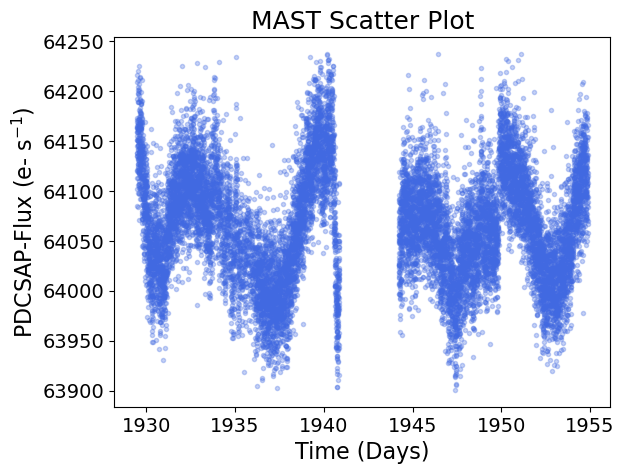

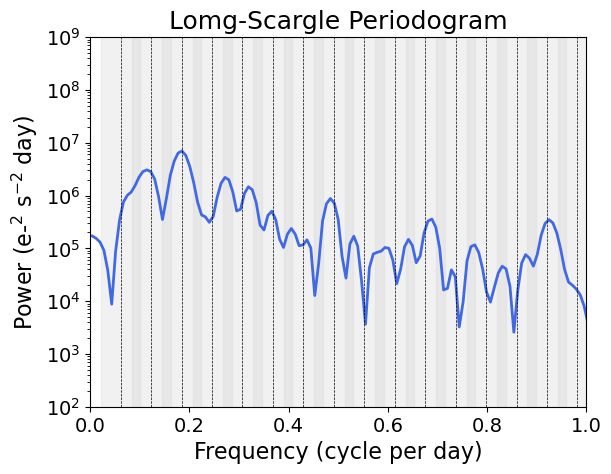

(0.18498682876210162, 3.0134354405346353, 5.405790275404033)

In [14]:
plot_MAST_file(MAST1)
plot_lomb_scargle(MAST1)
calculate_harmonic(MAST1)

## MAST GJ 3942 Data 2

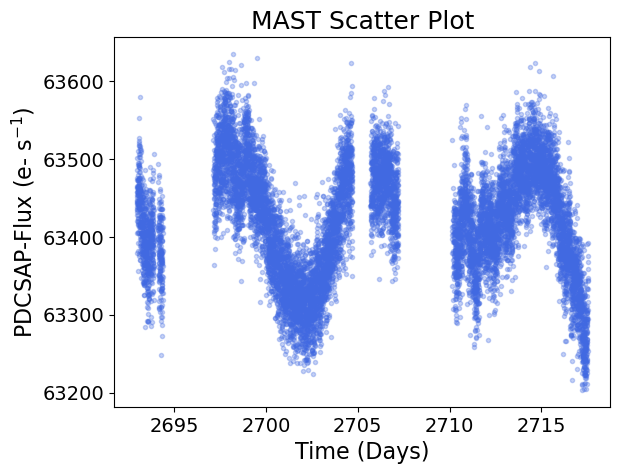

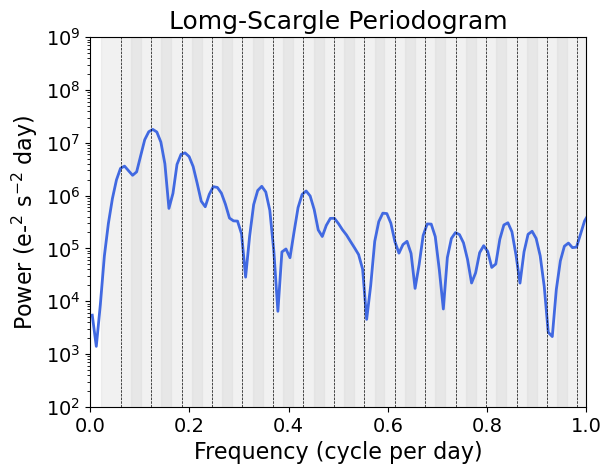

(0.12610260958127134, 2.0542115100789102, 7.930050007058055)

In [15]:
plot_MAST_file(MAST2)
plot_lomb_scargle(MAST2)
calculate_harmonic(MAST2)

## MAST GJ 3942 Data 3

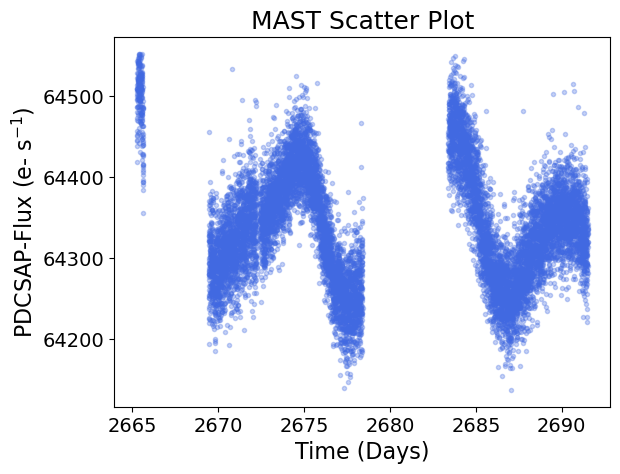

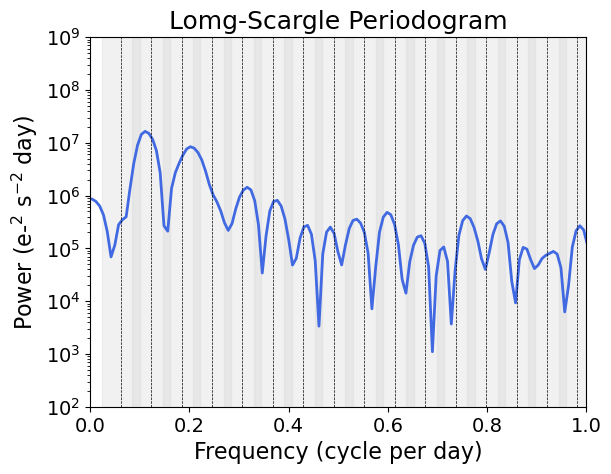

(0.11052801307477737, 1.8005013329881234, 9.04748011097832)

In [16]:
plot_MAST_file(MAST3)
plot_lomb_scargle(MAST3)
calculate_harmonic(MAST3)

## MAST GJ 3942 Data 4

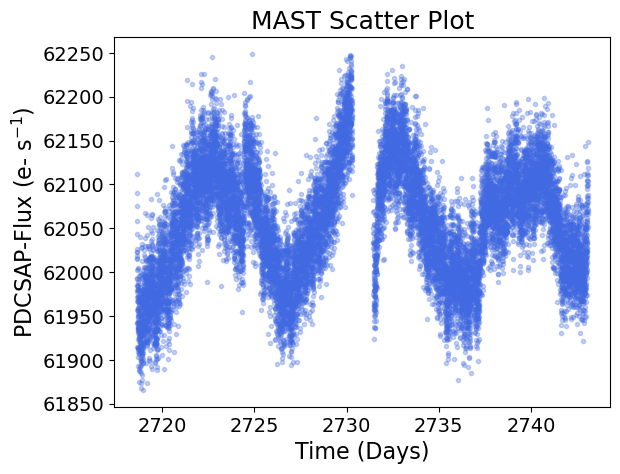

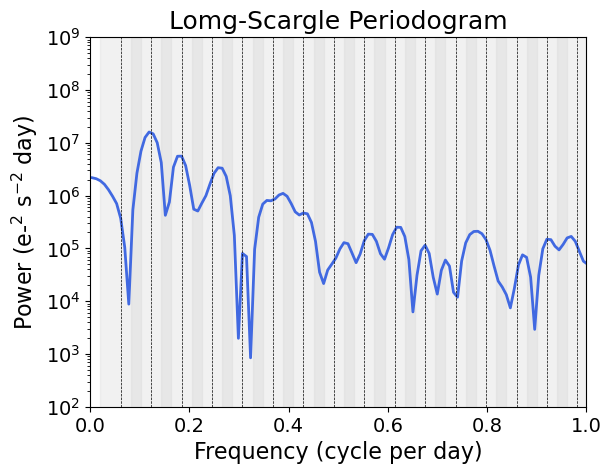

(0.11865894226140021, 1.9329541694382093, 8.427514866911975)

In [17]:
plot_MAST_file(MAST4)
plot_lomb_scargle(MAST4)
calculate_harmonic(MAST4)

## MAST GJ 3942 Data 5

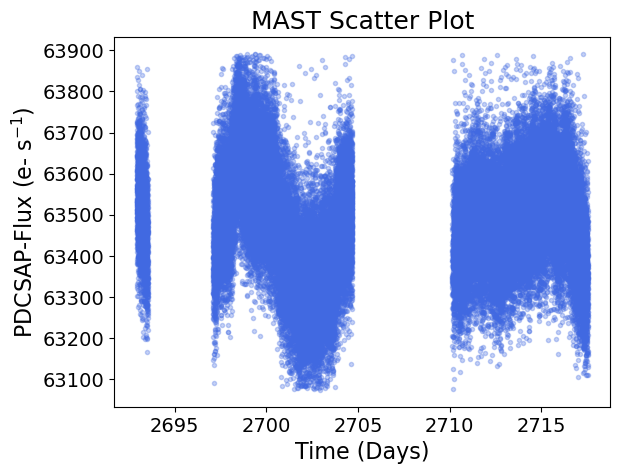

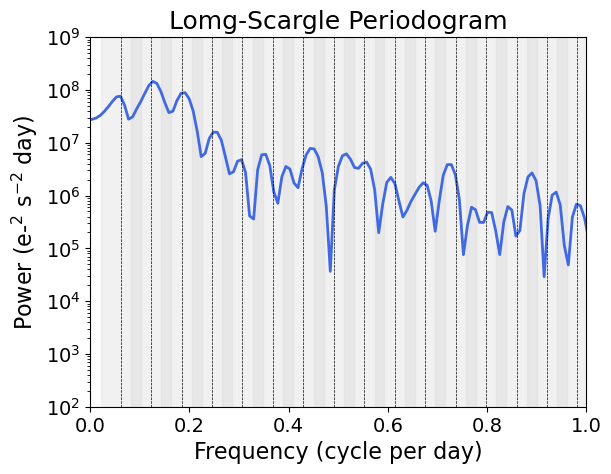

(0.12608005289779825, 2.0538440617051332, 7.931468753511787)

In [18]:
plot_MAST_file(MAST5)
plot_lomb_scargle(MAST5)
calculate_harmonic(MAST5)

## MAST GJ 3942 Data 6

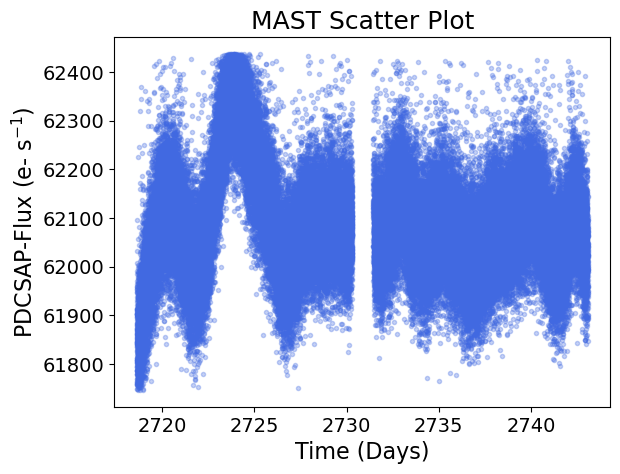

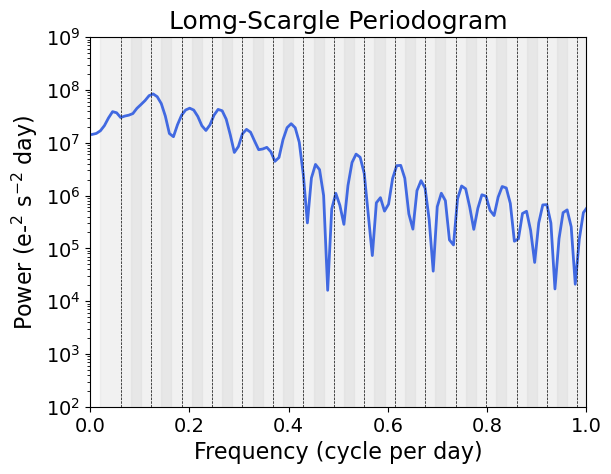

(0.12683390863007146, 2.066124371583864, 7.884326918573782)

In [19]:
plot_MAST_file(MAST6)
plot_lomb_scargle(MAST6)
calculate_harmonic(MAST6)

## MAST GJ 3942 Data 7

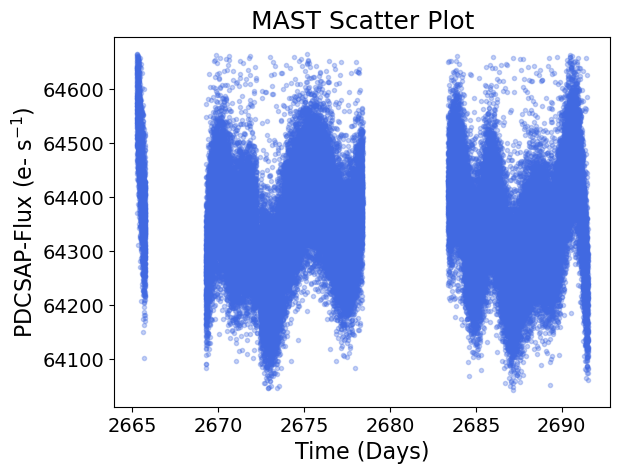

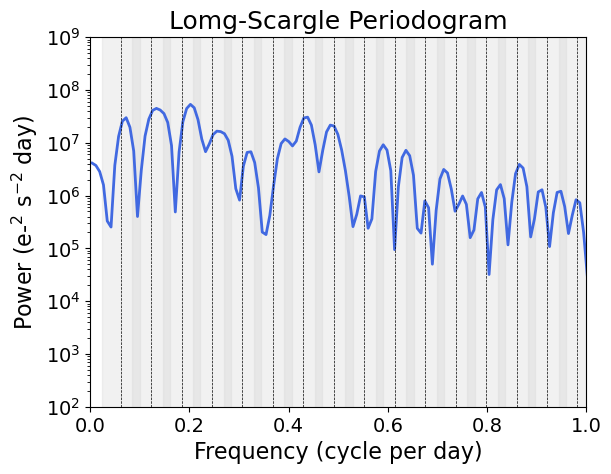

(0.20198343418724568, 3.290310142910232, 4.950901067822053)

In [20]:
plot_MAST_file(MAST7)
plot_lomb_scargle(MAST7)
calculate_harmonic(MAST7)

## Average Lomb-Scargle Periodogram

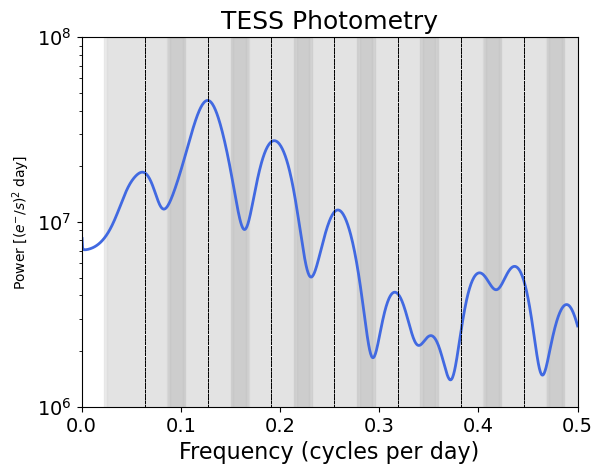

In [81]:
periodogram_array = generate_periodogram_matrix(mast_files)
plot_average_periodogram(periodogram_array, mast_files)
# decresased rp from 16.29 so the harmonics array best fits the peaks in the average periodogram for the TESS data.
# To find the value of the peaks, take the first deriviative,.
# in the message, p is the periodogram
# For minimize, use bounds fo 14.5 and 17.5
# could pass peaks into args for minimize; could hard-code it so wouldnt have to

# Best Fit Frequency (1st iteration)

In [147]:
def calculate_first_derivative(periodogram, delta_f):
    N = len(periodogram)
    first_derivative = np.zeros(N)
    
    for i in range(1, N-1):
        first_derivative[i] = (periodogram[i+1] - periodogram[i-1]) / (2 * delta_f)
        
    return first_derivative

In [148]:
def find_local_minima(f_grid, derivative): # local minima without find_peaks
    abs_derivative = np.abs(derivative)
    
    # Final local minima where the absolute value of the derivative is closest to zero
    local_minima = np.where((abs_derivative[:-2] > abs_derivative[1:-1]) &
                            (abs_derivative[1:-1] < abs_derivative[2:]))[0] + 1
    
    return local_minima

In [149]:
def plot_first_derivative(f_grid, first_derivative, local_minima):
    plt.plot(f_grid, np.abs(first_derivative))
    plt.scatter(f_grid[local_minima], np.abs(first_derivative)[local_minima], color='red', label='Local Minima')
    plt.xlabel('Frequency (cycles per day)', fontsize=16)
    plt.ylabel('Absolute Value of 1st Derivative', fontsize=16)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.title("1st Derivative of Average Periodogram", fontsize=18)
    plt.legend()
    plt.show()

In [150]:
def find_optimal_frequency(f_grid, periodogram):
    delta_f = f_grid[1] - f_grid[0]
    first_derivative = calculate_first_derivative(periodogram, delta_f)
    local_minima = find_local_minima(f_grid, first_derivative)
    return f_grid[local_minima]

In [151]:
def objective_function(frequency, f_grid, periodogram):
    # Using a model periodogram
    model_periodogram = np.sin(2 * np.pi * frequency * f_grid)
    return np.sum((periodogram - model_periodogram) ** 2)

In [152]:
def find_best_fit_frequency(f_grid, periodogram):
    result = minimize_scalar(objective_function, args=(f_grid, periodogram), bounds=(14.5, 17.5), method='bounded')
    return result.x

In [153]:
periodogram_array = generate_periodogram_matrix(mast_files)
f_grid = np.linspace(0, 0.5, num=1024)
average_periodogram = np.mean(periodogram_array, axis=1)

In [154]:
delta_f = f_grid[1] - f_grid[0]
first_derivative = calculate_first_derivative(average_periodogram, delta_f)
local_minima = find_local_minima(f_grid, first_derivative)

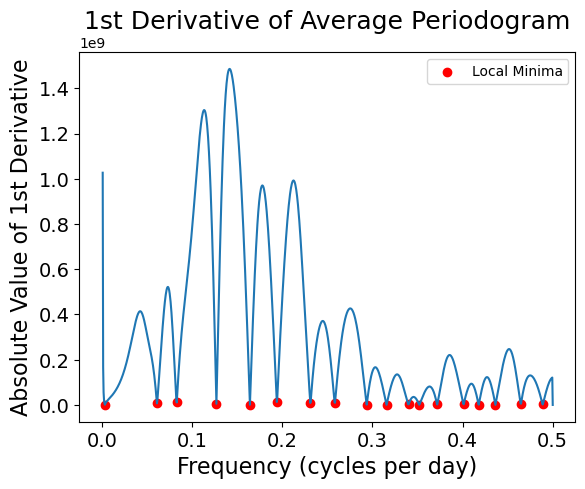

In [155]:
plot_first_derivative(f_grid, first_derivative, local_minima)

In [156]:
best_frequency = find_best_fit_frequency(f_grid, average_periodogram)
print("Best Fit Frequency: ", best_frequency)

Best Fit Frequency:  15.645898033750315


# Best Fit Frequency (2nd iteration)

In [251]:
def calculate_derivative(average_periodogram, delta_f):
    derivative = (average_periodogram[2:] - average_periodogram[:-2]) / (2 * delta_f)
    return derivative

In [252]:
def find_zero_derivative_points(derivative, f_grid):
    # Local minima in the absolute value of the derivative
    minima_indices, _ = find_peaks(-np.abs(derivative))
    # Corresponding frequencies where the minima occur
    minima_frequencies = f_grid[1:-1][minima_indices]    
    return minima_frequencies

In [253]:
def plot_derivative(derivative, f_grid):
    plt.figure()
    plt.plot(f_grid[1:-1], np.abs(derivative), color='orange', linewidth=2)
    plt.xlabel('Frequency (cycles per day)')
    plt.ylabel('Absolute Value of First Derivative')
    plt.title('Derivative of Average Periodogram')
    plt.grid(True)
    plt.show()

In [254]:
def analyze_peaks(f_grid, minima_frequencies):
    print("Frequencies where the derivative is close to zero: ")
    
    if len(minima_frequencies) > 0:
        for freq in minima_frequencies:
            print(f"Frequency: {freq:.6f} cycles per day")
            
    else:
        print("No frequencies found close to zero derivative.")

In [255]:
def objective_function(f_r, peak_frequencies):
    # Sum of remainders from peak frequencies divided by the guess rotation frequency (f_r)
    remainders = np.abs(peak_frequencies % f_r)
    return np.sum(remainders)

In [256]:
def find_best_fit_rf(peak_frequencies):
    # Set bounds on f_r (rotation frequency)
    lower_bound, upper_bound = 14.5, 17.5
    # Minimize the objective function
    result = minimize_scalar(objective_function, bounds=(lower_bound, upper_bound), args=(peak_frequencies,), method='bounded')
    if result.success:
        return result.x
    else:
        raise ValueError("Optimization failed. Try adjusting the bounds for initial guess.")

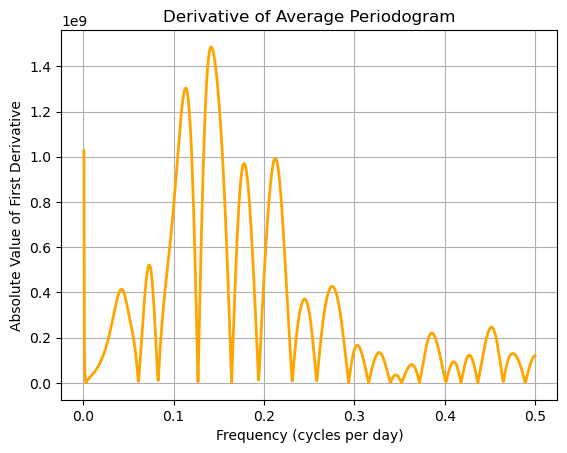

In [257]:
delta_f = f_grid[1] - f_grid[0]
average_periodogram = np.mean(periodogram_array, axis=1)
derivative = calculate_derivative(average_periodogram, delta_f)
plot_derivative(derivative, f_grid)

In [259]:
minima_frequencies = find_zero_derivative_points(derivative, f_grid)
analyze_peaks(f_grid, minima_frequencies)

Frequencies where the derivative is close to zero: 
Frequency: 0.003421 cycles per day
Frequency: 0.061095 cycles per day
Frequency: 0.083089 cycles per day
Frequency: 0.127077 cycles per day
Frequency: 0.164223 cycles per day
Frequency: 0.194037 cycles per day
Frequency: 0.231183 cycles per day
Frequency: 0.258553 cycles per day
Frequency: 0.293744 cycles per day
Frequency: 0.315738 cycles per day
Frequency: 0.340176 cycles per day
Frequency: 0.351906 cycles per day
Frequency: 0.371945 cycles per day
Frequency: 0.401271 cycles per day
Frequency: 0.417889 cycles per day
Frequency: 0.436461 cycles per day
Frequency: 0.464809 cycles per day
Frequency: 0.488759 cycles per day


In [261]:
m = 4 # Change based on number of first m number of minima to account for
best_fit_frequency = find_best_fit_rf(minima_frequencies[:m]) 
print(f"Best-fit rotation frequency: {best_fit_frequency:.6f} cycles per day")

Best-fit rotation frequency: 17.499993 cycles per day


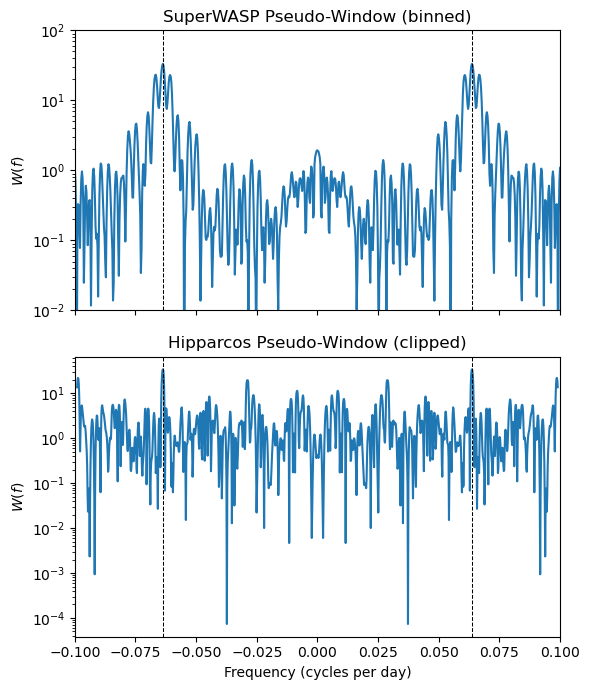

In [270]:
# Figure with stacked pseudo-window plots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6, 7))


# First plot (SuperWASP)
ax1.set_title("SuperWASP Pseudo-Window (binned)")
ax1.set_ylabel(r"$W(f)$")
freq, specwin = LombScargle(bin_time - bin_time[0], np.sin(2 * np.pi * (bin_time - bin_time[0]) / rp), center_data=False, fit_mean=False, normalization='psd').autopower(nyquist_factor=2)
ax1.semilogy(np.concatenate((-freq[::-1], freq[1:])), np.concatenate((specwin[::-1], specwin[1:])))
ax1.set_ylim(1e-2, 1e2)
ax1.axvline(1 / rp, linestyle='--', linewidth=0.75, color='black')
ax1.axvline(-(1 / rp), linestyle='--', linewidth=0.75, color='black')

# Second Plot (Hipparcos)
ax2.set_title("Hipparcos Pseudo-Window (clipped)")
ax2.set_ylabel(r"$W(f)$")
ax2.set_xlabel(r"Frequency (cycles per day)")
freq, specwin = LombScargle(bjd - bjd[0], np.sin(2 * np.pi * (bjd - bjd[0]) / rp), center_data=False, fit_mean=False, normalization='psd').autopower(nyquist_factor=2)
ax2.semilogy(np.concatenate((-freq[::-1], freq[1:])), np.concatenate((specwin[::-1], specwin[1:])))
ax2.set_xlim(-0.1, 0.1)
ax2.axvline(1 / rp, linestyle='--', linewidth=0.75, color='black')
ax2.axvline(-(1 / rp), linestyle='--', linewidth=0.75, color='black')

# Adjust layout (prevent overlap)
plt.tight_layout()

plt.show()

#0 average lombscargle of data sets, np.mean dim/access = 0 (taking the average of all lombscargle data; it would have to be within an array).
get individual peridograms of each dataset; combine lombscargle data, average peridograms .
For SuperWASP, do not use nyquist_factor to get the lombscargle of its data (It will use a default nyquist_factor of 5).

#1
For data with outliners, try sigma clipping to get them out of the way of the data you want to anaylsis, like in data set 6.
For the average peridogram, just take the average of the power.
Find peaks at odd harmonics of 32 period. Drop vertial lines at odd harmonics in the xlim plots and see if there are peaks there to support our claim.

#2
Bin SuperWASP data to 1 day timestamp using the Lightkurve package, getting the Lombs-Scargle and plotting the periodgram. Work on binning this data set, as the max index of power takes the highest power of the frequency, which is the peak due to artifacting of the day-night cycle being captured.
Sigma clip the data sets, including SuperWASP; create function to do it.
Create functions to streamline notebook.

#3 shade vertical lines to + one resolution and - one resolution. You can take the average of the resolution for all datasets (below), and use it as a shaded border for the lines. Increase text size, add frequnecy units, change color, increase line thickness. add units to the TESS Photometry.

#4 clean up SuperWASP cells. Find how many points are in the binned lightcurve for the SuperWASP data. There are going to be NaN points in the array of the binned lightcurve; cut out the NaN points, and find actual data point amount. Use scatter plot. find frequency of maximum power (peak) of the binned lightcurve (log plot); find frequency and period associaited with it. Note, other data to look at can include the Hipparcos from NASA exoplanet archive. (1st object)

#5 bin_time = my_lightcurve_bin_new.time.value [3]. Do pseudo window for binned lighcurve, i.e. [1] and [2]. Plot Hipparcos data. Get time values of nonbinned data using [3] and make a spectral window; see if the peak is at the rotation period of the moon to affirm that it is coming from noise. (1/29.5;  make vertical line). Look into getting access to APACHE and EXORAP programs (pg. 7 of paper).

#6 Run speactral and psudeo window of Hipparcos data. Find wave length coverage of the filters of test filter (MAST), SuperWASP filter, and Hipparcos (Hp filter). Move superWASP data to seperate notebook. Add shaded resoulution to hipparcos. For later, detrend Hipparcos.

#7 Run speactral and psudeo window of Hipparcos data. Find wave length coverage of the filters of test filter (MAST), SuperWASP filter, and Hipparcos (Hp filter). Move superWASP data to seperate notebook. Add shaded resoulution to hipparcos. For later, detrend Hipparcos. Look at observation period for TESS, Hipparcos, and SuperWASP.

Summary For the three datasets:
SuperWASP didn't have enough precison due to its coverage as a sky survey, with interferene with the atmosphere.
For Hipparcos, we weren't able to find a solid rotation frequency due to the timing of the observations, and due to low amount of observations in the dataset (~110 points).
The TESS data, from MAST, was able to find harmonics of a rotation period of ~16 days using its star brightness to validate its rotation, 

Start 500 words summary of what was learned of the photometry using these three datasets.
Try to detring Hipparcos with a best fit line, then subtract the line from the data. Should flatten out.

Sources:

Data Tables:
https://exoplanetarchive.ipac.caltech.edu/overview/GJ%203942
https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html


Filters:
http://svo2.cab.inta-csic.es/svo/theory/fps3/index.php?id=Hipparcos/Hipparcos.Hp
http://svo2.cab.inta-csic.es/theory/fps/index.php?id=WASP/SuperWASP.SW&&mode=browse&gname=WASP&gname2=SuperWASP#filter
http://svo2.cab.inta-csic.es/theory/fps/index.php?id=TESS/TESS.Red&&mode=browse&gname=TESS&gname2=TESS#filter
